In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'axes.spines.top': False, 'axes.spines.right': False, 'savefig.dpi': 1200})
import numpy as np
import torch
from stable_baselines3 import PPO

from irc.agents import BeliefAgentFamily

from boxforage.single_box import SingleBoxForaging
from boxforage.multi_box import IdenticalBoxForaging
from boxforage.utils import plot_single_box_episode, plot_multi_box_episode

# Single Box Foraging Experiment
There is only one box in the environment, whose monochromatic color cue hints whethere there is a food inside. Food will appear with probability $p_\mathrm{appear}$ at each time step if the agent does not open the box. When the agent opens the box and attempts to collect food, it receives a negative reward $r_\mathrm{fetch}$ regardless of the outcome. If there is food in the box, the agent receives an additional positive reward $r_\mathrm{food}$ and the food is consumed.

Color cue of the box is drawn from a binomial distribution with parameter $n$ fixed and $p$ dependent on the true box state. When the food exists, $p=p_\mathrm{cue}$. When the food does not exist, $p=1-p_\mathrm{cue}$. The environment parameters of interest are $p_\mathrm{appear}$, $p_\mathrm{cue}$ and $r_\mathrm{food}$ (we fix $r_\mathrm{fetch}$ as -1).

## Optimal agent with the correct assumption

In [45]:
env_spec = {
    'box': {'p_appear': 0.1, 'p_cue': 0.6},
    'reward': {'food': 5.},
}
env = SingleBoxForaging(env_spec=env_spec)

Environment specification: {'box': {'p_appear': 0.1, 'p_cue': 0.6, 'num_shades': 5}, 'reward': {'food': 5.0, 'fetch': -1.0}}
Environment parameter: (0.1, 0.6, 5.0)


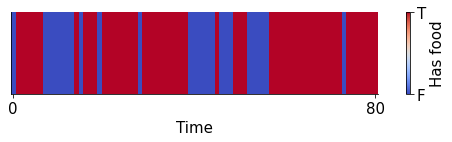

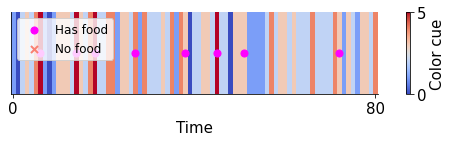

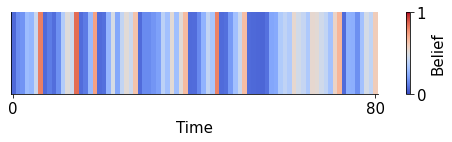

In [46]:
env_param = env.get_env_param()
print('Environment specification: {}'.format(env.env_spec))
print('Environment parameter: {}'.format(env_param))

bafam = BeliefAgentFamily(SingleBoxForaging, s_path_len=3) # base object for IRC operations
num_steps = 80
agent_0 = bafam.optimal_agent(env_param)
figs = plot_single_box_episode(agent_0, env, num_steps)

In [5]:
reward_rates = []
for _ in range(16):
    episode = agent_0.run_one_episode(env, num_steps)
    reward_rates.append(episode['rewards'].mean())
print('Reward rate {:.2f} ({:.2f})'.format(np.mean(reward_rates), np.std(reward_rates)))

Reward rate 0.25 (0.07)


## Rational agent with incorrect assumption

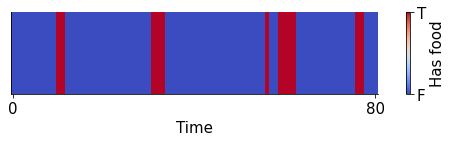

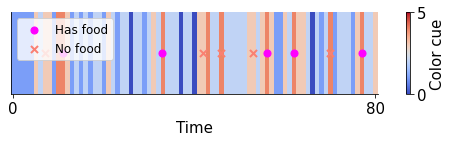

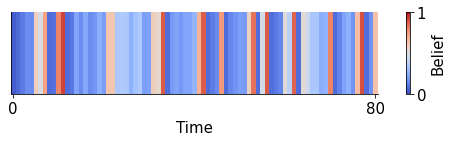

In [48]:
env_param = (0.25, 0.7, 10)
agent_1 = bafam.optimal_agent(env_param)
figs = plot_single_box_episode(agent_1, env, num_steps)

In [11]:
reward_rates = []
for _ in range(16):
    episode = agent_1.run_one_episode(env, num_steps)
    reward_rates.append(episode['rewards'].mean())
print('Reward rate {:.2f} ({:.2f})'.format(np.mean(reward_rates), np.std(reward_rates)))

Reward rate 0.15 (0.13)


## Calculate log likelihood of actions and observations

In [49]:
episode = agent_1.run_one_episode(env, num_steps)
actions, obss = episode['actions'], episode['obss']

In [13]:
logps_0 = agent_0.episode_likelihood(actions, obss, num_repeats=8)
logps_1 = agent_1.episode_likelihood(actions, obss, num_repeats=8)

In [14]:
from scipy.special import logsumexp

logp_0 = logsumexp(logps_0)-np.log(len(logps_0))
logp_1 = logsumexp(logps_1)-np.log(len(logps_1))

print('Log likelihood of data from agent 0: {:.1f}'.format(logp_0))
print('Log likelihood of data from agent 1: {:.1f}'.format(logp_1))

Log likelihood of data from agent 0: -223.7
Log likelihood of data from agent 1: -7.0


## Posterior of models

In [55]:
p_appear_list = [0.05, 0.15, 0.25]
p_cue_list = [0.1, 0.3, 0.5, 0.7, 0.9]
# r_food_list = [2, 5, 10]
r_food = 10

logps_array = np.zeros((len(p_appear_list), len(p_cue_list)))
for i, p_appear in enumerate(p_appear_list):
    for j, p_cue in enumerate(p_cue_list):
        env_param = (p_appear, p_cue, r_food)
        print(f"Calculating log likelihood from optimal agent for {env_param}...")
        agent = bafam.optimal_agent(env_param)
        logps = agent.episode_likelihood(actions, obss, num_repeats=8)
        logps_array[i, j] = logsumexp(logps)

Calculating log likelihood from optimal agent for (0.05, 0.1, 10)...
Calculating log likelihood from optimal agent for (0.05, 0.3, 10)...
Calculating log likelihood from optimal agent for (0.05, 0.5, 10)...
Calculating log likelihood from optimal agent for (0.05, 0.7, 10)...
Calculating log likelihood from optimal agent for (0.05, 0.9, 10)...
Calculating log likelihood from optimal agent for (0.15, 0.1, 10)...
Calculating log likelihood from optimal agent for (0.15, 0.3, 10)...
Calculating log likelihood from optimal agent for (0.15, 0.5, 10)...
Calculating log likelihood from optimal agent for (0.15, 0.7, 10)...
Calculating log likelihood from optimal agent for (0.15, 0.9, 10)...
Calculating log likelihood from optimal agent for (0.25, 0.1, 10)...
Calculating log likelihood from optimal agent for (0.25, 0.3, 10)...
Calculating log likelihood from optimal agent for (0.25, 0.5, 10)...
Calculating log likelihood from optimal agent for (0.25, 0.7, 10)...
Calculating log likelihood from op

true parameters:
p_appear=0.25, p_cue=0.7


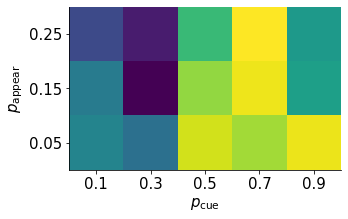

In [61]:
print('true parameters:\np_appear=0.25, p_cue=0.7')
_, ax = plt.subplots(figsize=(5, 3))
ax.imshow(logps_array, origin='lower')
ax.set_xticks(np.arange(len(p_cue_list)))
ax.set_xticklabels([str(p) for p in p_cue_list])
ax.set_xlabel(r'$p_\mathrm{cue}$')
ax.set_yticks(np.arange(len(p_appear_list)))
ax.set_yticklabels([str(p) for p in p_appear_list])
ax.set_ylabel(r'$p_\mathrm{appear}$')
plt.show()
# TODO multiple "rational" agents are needed for a given environment parameter.

# Two Box Foraging Experiment
Two boxes are positioned in a room, and the agent can travel to their locations and an additional location 'CENTER'. Food can appear or vanish with a fixed probability at each time step if the agent does not open the box. The color cue again is drawn from a binomial distribution, with $p$ parameter dependent on the box state.

We assume there is a travel cost associate with each arrived location, i.e. moving is punished. As in the single box case, open the box also results a negative reward $r_\mathrm{fetch}$ regardless of the outcome.

## Optimal agent with the correct assumption

In [71]:
env_spec = {
    'boxes': {'p_appear': 0.2, 'p_vanish': 0.1, 'p_true': 0.6, 'p_false': 0.4},
}
env = IdenticalBoxForaging(env_spec=env_spec)

Environment specification: {'boxes': {'p_appear': array([0.2, 0.2]), 'p_vanish': array([0.1, 0.1]), 'p_true': array([0.6, 0.6]), 'p_false': array([0.4, 0.4]), 'num_boxes': 2, 'num_shades': 5}, 'reward': {'food': 10.0, 'fetch': -2.0, 'move_box': -1.0, 'move_center': -0.5, 'move': array([-1. , -1. , -0.5])}}
Environment parameter: [ 0.2  0.1  0.6  0.4 10.  -1.  -1.  -0.5]


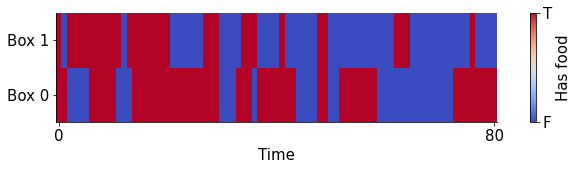

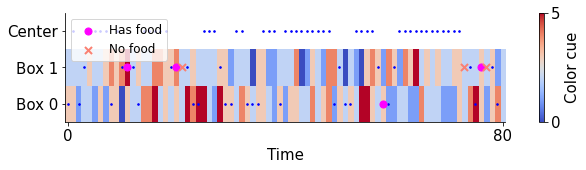

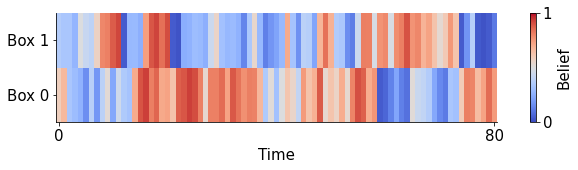

In [19]:
env_param = env.get_env_param()
print('Environment specification: {}'.format(env.env_spec))
print('Environment parameter: {}'.format(env_param))

est_spec = { # distribution estimation specification
    'state_prior': {
        'num_samples': 20000,
        'optim_kwargs': {
            'batch_size': 128, 'num_epochs': 40,
        },
    },
    'obs_conditional': {
        'num_samples': 20000,
        'optim_kwargs': {
            'batch_size': 128, 'num_epochs': 40,
        },
    },
    'belief': {
        'num_samples': 800,
        'optim_kwargs': {
            'batch_size': 64, 'num_epochs': 10,
        },
    },
}
bafam = BeliefAgentFamily(
    IdenticalBoxForaging,
    model_kwargs={'est_spec': est_spec},
    state_dist_kwargs={'idxs': [[0], [1], [2]]}, # independent assumption about state
    obs_dist_kwargs={'idxs': [[0], [1], [2]]}, # independent assumption about observation
    s_path_len=3,
) # base object for IRC operations
agent_0 = bafam.optimal_agent(env_param)
figs = plot_multi_box_episode(agent_0, env, num_steps, figsize=(12, 2))

In [20]:
reward_rates = []
for _ in range(16):
    episode = agent_0.run_one_episode(env, num_steps)
    reward_rates.append(episode['rewards'].mean())
print('Reward rate {:.2f} ({:.2f})'.format(np.mean(reward_rates), np.std(reward_rates)))

Reward rate 0.25 (0.35)


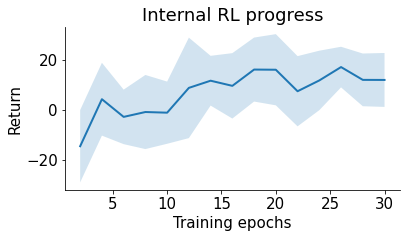

In [41]:
env_param = [0.2, 0.1, 0.6, 0.4, 10, -1, -1, -0.5]
config = bafam.to_config(env_param)
_, ckpt = bafam.load_ckpt(config)
e_idxs, r_means, r_stds = [], [], []
for e_idx, eval_record in ckpt['eval_records'].items():
    e_idxs.append(e_idx)
    r_means.append(np.mean(eval_record['returns']))
    r_stds.append(np.std(eval_record['returns']))
e_idxs, r_means, r_stds = np.array(e_idxs), np.array(r_means), np.array(r_stds)

_, ax = plt.subplots(figsize=(6, 3))
ax.plot(e_idxs, r_means)
ax.fill_between(e_idxs, r_means-r_stds, r_means+r_stds, alpha=0.2)
ax.set_xlabel('Training epochs')
ax.set_ylabel('Return')
ax.set_title('Internal RL progress')
plt.show()

## Rational agent with incorrect assumption

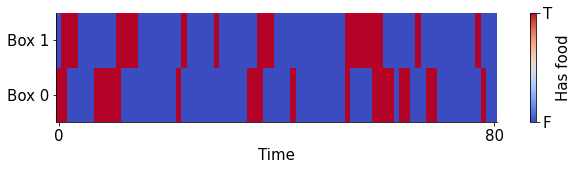

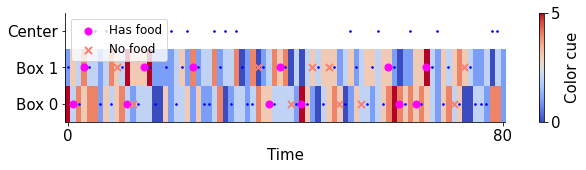

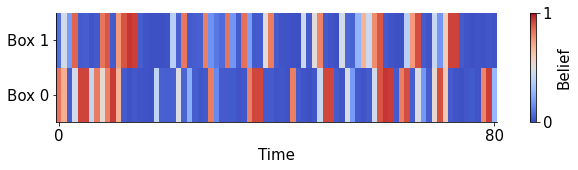

In [21]:
env_param = [0.15, 0.05, 0.8, 0.2, 10, -1, -1, -0.5]
agent_1 = bafam.optimal_agent(env_param)
figs = plot_multi_box_episode(agent_1, env, num_steps, figsize=(12, 2))

In [22]:
reward_rates = []
for _ in range(16):
    episode = agent_1.run_one_episode(env, num_steps)
    reward_rates.append(episode['rewards'].mean())
print('Reward rate {:.2f} ({:.2f})'.format(np.mean(reward_rates), np.std(reward_rates)))

Reward rate 0.43 (0.30)


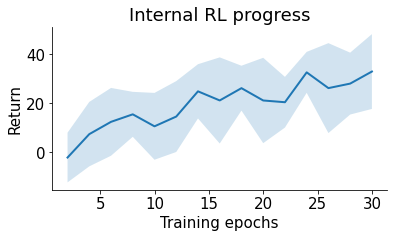

In [40]:
env_param = [0.15, 0.05, 0.8, 0.2, 10, -1, -1, -0.5]
config = bafam.to_config(env_param)
_, ckpt = bafam.load_ckpt(config)
e_idxs, r_means, r_stds = [], [], []
for e_idx, eval_record in ckpt['eval_records'].items():
    e_idxs.append(e_idx)
    r_means.append(np.mean(eval_record['returns']))
    r_stds.append(np.std(eval_record['returns']))
e_idxs, r_means, r_stds = np.array(e_idxs), np.array(r_means), np.array(r_stds)

_, ax = plt.subplots(figsize=(6, 3))
ax.plot(e_idxs, r_means)
ax.fill_between(e_idxs, r_means-r_stds, r_means+r_stds, alpha=0.2)
ax.set_xlabel('Training epochs')
ax.set_ylabel('Return')
ax.set_title('Internal RL progress')
plt.show()

## Calculate log likelihood of actions and observations

In [23]:
episode = agent_1.run_one_episode(env, num_steps)
actions, obss = episode['actions'], episode['obss']

In [24]:
logps_0 = agent_0.episode_likelihood(actions, obss, num_repeats=8)
logps_1 = agent_1.episode_likelihood(actions, obss, num_repeats=8)

In [25]:
from scipy.special import logsumexp

logp_0 = logsumexp(logps_0)-np.log(len(logps_0))
logp_1 = logsumexp(logps_1)-np.log(len(logps_1))

print('Log likelihood of data from agent 0: {:.1f}'.format(logp_0))
print('Log likelihood of data from agent 1: {:.1f}'.format(logp_1))

Log likelihood of data from agent 0: -105.5
Log likelihood of data from agent 1: -46.8
